In [18]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import hybrid
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import curve_fit
from joblib import Parallel
from dwave.cloud.api import Problems
from utils import instance_reader
import numpy as np
import pickle
import matplotlib.pyplot as plt
import hybrid
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import curve_fit
from joblib import Parallel
from dwave.cloud.api import Problems

from dwave.embedding.chain_strength import uniform_torque_compensation
from dwave.embedding.chain_breaks import majority_vote, broken_chains
import dimod

In [58]:
cha = lambda bqm: uniform_torque_compensation(bqm = bqm, prefactor=2)

In [59]:
callable(cha)

True

RQ1.1 chain strengths

In [16]:
densities = [round(0.05 + 0.05*i, 2) for i in range(20)]  # 20
sizes = [25+10*i for i in range(16)] # 16

In [17]:
def unembed_sampleset_mine(sampleset, embedding, bqm, chain_break_fraction=False):
    variables = list(bqm.variables)  # need this ordered
    try:
        chains = [embedding[v] for v in variables]
    except KeyError:
        raise ValueError("given bqm does not match the embedding")

    record = sampleset.record

    unembedded, idxs = majority_vote(sampleset, chains)

    reserved = {'sample', 'energy'}
    vectors = {name: record[name][idxs]
            for name in record.dtype.names if name not in reserved}
    
    if chain_break_fraction:
        broken = broken_chains(sampleset, chains)
        if broken.size:
            vectors['chain_break_fraction'] = broken.mean(axis=1)[idxs]
        else:
            vectors['chain_break_fraction'] = 0

    info = sampleset.info.copy()

    return dimod.SampleSet.from_samples_bqm((unembedded, variables),
                                            bqm,
                                            info=info,
                                            **vectors)



In [8]:
with open("pickles/RQ1.1_saved_data.pkl" , "rb") as f:
    [acl, num_qubits, energies, unembedded_energies, reference_energies, relative_errors, unembedded_relative_errors] = pickle.load(f)
    container = pickle.load(f)

median_relative_errors = np.median(relative_errors, axis = -1)
median_unembedded_relative_errors = np.median(unembedded_relative_errors, axis = -1)

median_broken_chain_fraction = np.zeros(np.shape(median_relative_errors))
for den in range(20):
    for size in range(16):
        for problem_idx in range(5):
            bqm = container[80*den+5*size+problem_idx][0]
            for embedding_idx in range(10):
                embedding, sampleset, _, _, _, _, _ = container[80*den+5*size+problem_idx][1][embedding_idx]
                if embedding:
                    broken_chain_fraction_list = []
                    for i in unembed_sampleset_mine(sampleset, embedding, bqm, chain_break_fraction=True).record:
                        broken_chain_fraction_list.append(i[-1])
                    median_broken_chain_fraction[den, size, problem_idx, embedding_idx] = np.median(broken_chain_fraction_list)
                else:
                    median_broken_chain_fraction[den, size, problem_idx, embedding_idx] = np.nan

In [34]:
chain_strengths = np.zeros((20,16, 5))
for den in range(20):
    for size in range(16):
        for problem_idx in range(5):
            bqm = container[80*den+5*size+problem_idx][0]
            chain_strengths[den, size, problem_idx] = uniform_torque_compensation(bqm)

In [32]:
np.shape(np.mean(median_broken_chain_fraction))

(20, 16, 5, 10)

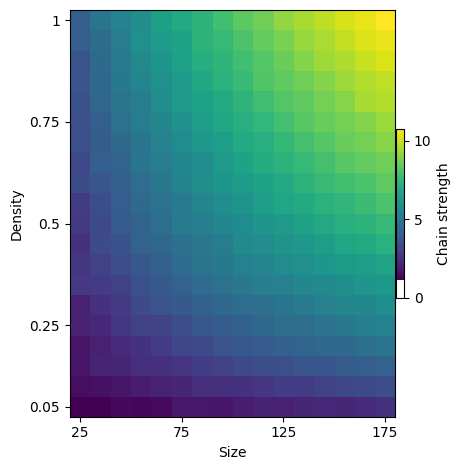

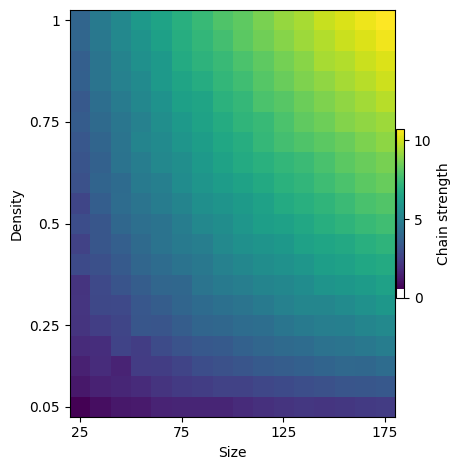

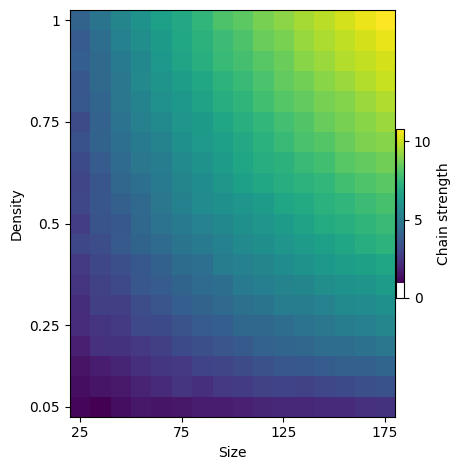

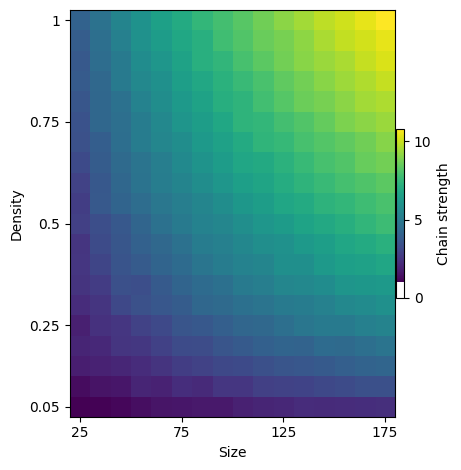

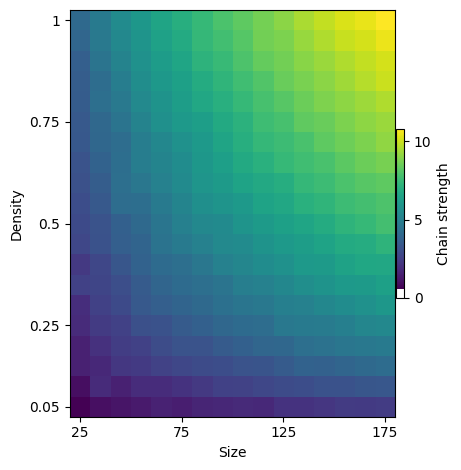

In [37]:
for problem_idx in range(5):
    fig, ax = plt.subplots()
    im = plt.imshow(chain_strengths[:, :, problem_idx])
    ax.invert_yaxis()
    # ax.set_title('a) Average ACL per graph density and size.', fontsize=10)
    ax.set_xlabel('Size', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.set_xticks(range(0,len(sizes),5),labels = [25, 75, 125, 175])

    ax.set_yticks([0,4,9,14,19],labels = [0.05,0.25,0.5,0.75,1])
    # ax.set_yticks([1, 5, 10, 15, 20], labels=[0.05, 0.25, 0.5, 0.75, 1])

    # Add color bar
    cbar = plt.colorbar(im, fraction = 0.015, pad=0.0008)
    cbar.set_label('Chain strength', fontsize=10)
    cbar.set_ticks(range(0,15,5))
    cbar.set_ticklabels(range(0,15,5))
    plt.tight_layout()
    plt.show()


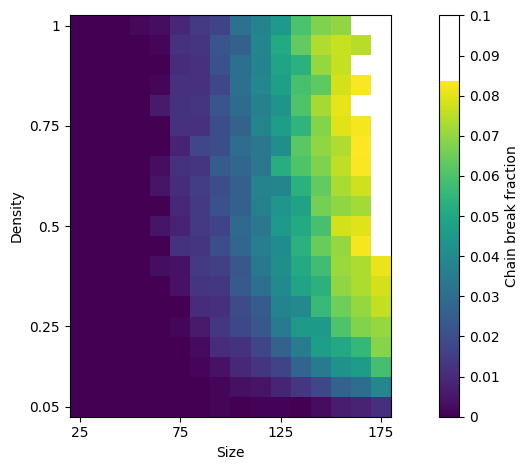

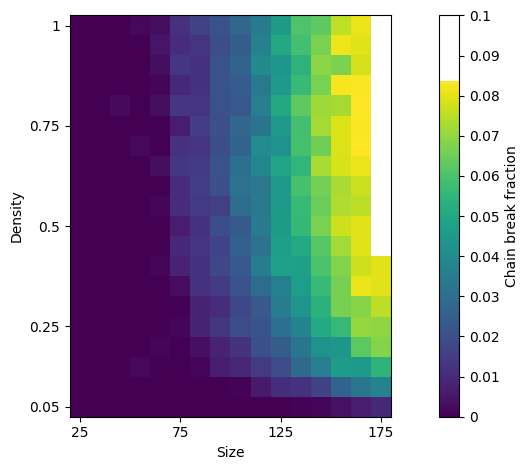

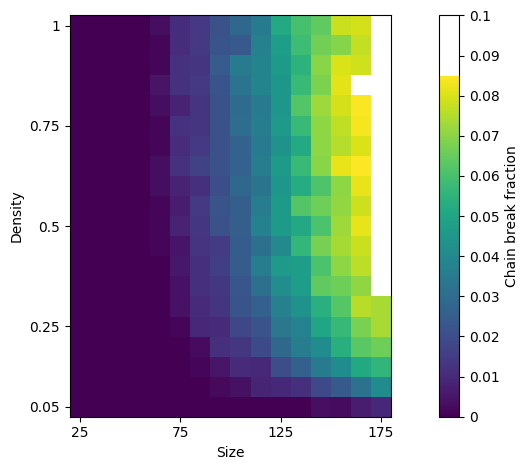

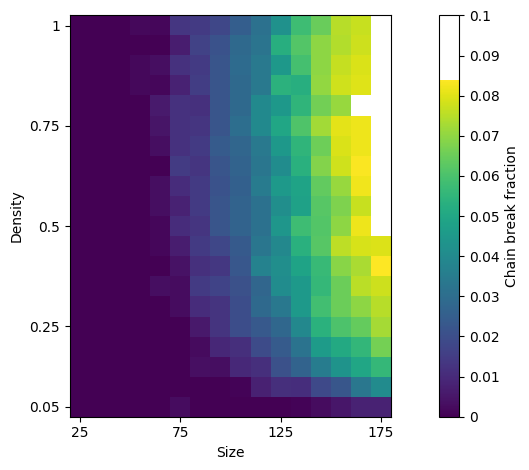

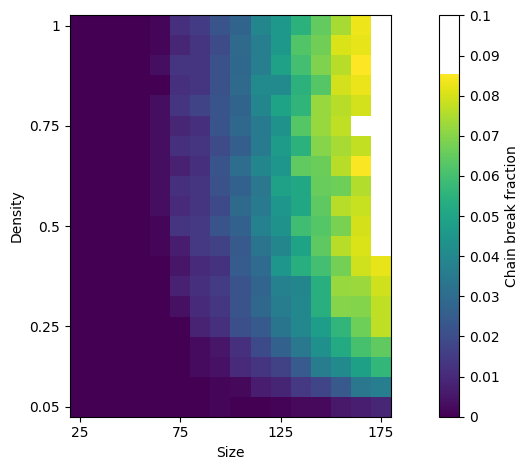

In [54]:
for problem_idx in range(5):
    fig, ax = plt.subplots()
    im = plt.imshow(np.mean(median_broken_chain_fraction[:, :, problem_idx, :], axis=-1))
    ax.invert_yaxis()
    # ax.set_title('a) Average ACL per graph density and size.', fontsize=10)
    ax.set_xlabel('Size', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.set_xticks(range(0,len(sizes),5),labels = [25, 75, 125, 175])

    ax.set_yticks([0,4,9,14,19],labels = [0.05,0.25,0.5,0.75,1])
    # ax.set_yticks([1, 5, 10, 15, 20], labels=[0.05, 0.25, 0.5, 0.75, 1])

    # Add color bar
    cbar = plt.colorbar(im, fraction = 0.15, pad=0.08)
    cbar.set_label('Chain break fraction', fontsize=10)
    cbar.set_ticks([0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1])
    cbar.set_ticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1])
    plt.tight_layout()
    plt.show()


In [47]:
np.nanmax(median_broken_chain_fraction)

0.136